# Setup

Install Segmentation Models

In [ ]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Begin by mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d johnowhitaker/opencities-masked-256

 97% 321M/331M [00:02<00:00, 183MB/s]
100% 331M/331M [00:02<00:00, 122MB/s]


In [ ]:
!unzip '/content/opencities-masked-256.zip'

Streaming output truncated to the last 5000 lines.
  inflating: mid_train/data/images-256/acc_d41d81_58_19_261846_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_59_19_261847_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_5_19_261866_253986.png  
  inflating: mid_train/data/images-256/acc_d41d81_60_19_261848_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_61_19_261849_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_62_19_261850_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_63_19_261851_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_64_19_261857_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_65_19_261858_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_66_19_261859_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_67_19_261860_253991.png  
  inflating: mid_train/data/images-256/acc_d41d81_68_19_261861_253991.png  
  inflating: mid_train/data/images-256

Do the necessary imports

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D, Dropout
from keras.models import Model
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

In [ ]:
import shutil
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load Data

In [ ]:
image_path1='/content/mid_train/data/images-256/'
image_path2='/content/mini_train/data/images-256/'
all_image_paths = [image_path1+file for file in os.listdir(image_path1)]+[image_path2+file for file in os.listdir(image_path2)]

In [ ]:
label_path1='/content/mid_train/data/masks-256/'
label_path2='/content/mini_train/data/masks-256/'
all_masks_paths=[label_path1+file for file in os.listdir(label_path1)]+[label_path2+file for file in os.listdir(label_path2)]

In [ ]:
len(all_image_paths)

3286

In [ ]:
all_images_paths=sorted(all_image_paths)
all_masks_paths=sorted(all_masks_paths)

## Restructure data organization

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#define function that creates the directories needed 

root_dir = '/content/data'
def create_directories(root_dir): 
  os.makedirs(os.path.join(root_dir, 'training/images/img'))
  os.makedirs(os.path.join(root_dir, 'training/masks/img'))
  os.makedirs(os.path.join(root_dir, 'validation/images/img'))
  os.makedirs(os.path.join(root_dir, 'validation/masks/img'))


create_directories(root_dir)

In [ ]:
#define function that writes the data into corresponding directories

def split_data(all_images, all_masks, training_dir, validation_dir, split_size): 

  assert len(all_images) == len(all_masks) 
  training_size = int(len(all_images) * (1-split_size))

  print("[INFO] DEFINING TRAINING AND VALIDATION IMAGES")
  training_images = all_images[:training_size]
  training_masks = all_masks[:training_size]
  val_images = all_images[training_size:]
  val_masks = all_masks[training_size:]

  print("[INFO] DEFINING NEEDED PATHS")
  training_images_path = os.path.join(training_dir, 'images/img')
  training_masks_path = os.path.join(training_dir, 'masks/img')
  val_images_path = os.path.join(validation_dir, 'images/img')
  val_masks_path = os.path.join(validation_dir, 'masks/img')

  print("[INFO] COPYING IMAGES")
  for i in range(len(training_images)):
    img_index = str(i) + '.png'
    shutil.copy2(training_images[i], os.path.join(training_images_path, img_index))
    shutil.copy2(training_masks[i], os.path.join(training_masks_path, img_index))
  for i in range(len(val_images)):
    img_index = str(i) + '.png'
    shutil.copy2(val_images[i], os.path.join(val_images_path, img_index))
    shutil.copy2(val_masks[i], os.path.join(val_masks_path, img_index))


In [ ]:
split_data(all_images_paths, all_masks_paths, '/content/data/training', '/content/data/validation', 0.3)

[INFO] DEFINING TRAINING AND VALIDATION IMAGES
[INFO] DEFINING NEEDED PATHS
[INFO] COPYING IMAGES


Restructure data folders so that we can use them by the Image Data Generator

## Load the Restructured Data

In [ ]:
IMAGE_SIZE = 256

In [ ]:
train_images_path = "/content/data/training/images/img"
train_masks_path = "/content/data/training/masks/img"
val_images_path = "/content/data/validation/images/img"
val_masks_path = "/content/data/validation/masks/img"

In [ ]:
def get_image_paths(source_dir): 
  return [os.path.join(source_dir, path) for path in os.listdir(source_dir)]

Define some helper fucntions

In [ ]:
IMAGE_SIZE = 256

def open_images(paths, is_mask=False):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        if is_mask:
          image = np.mean(image, axis=-1)/255.0
        else:
          image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [ ]:
def plot_images(sample_image, sample_mask, title):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18.5, 10.5)
  fig.suptitle(title)
  ax1.imshow(sample_image, cmap='gray')
  ax2.imshow(sample_mask, cmap='gray') 

In [ ]:
train_images = get_image_paths(train_images_path)
print(f"LOADED {len(train_images)} IMAGES FOR TRAINING")
train_masks = get_image_paths(train_masks_path)
assert len(train_images) == len(train_masks)


val_images = get_image_paths(val_images_path)
print(f"LOADED {len(val_images)} IMAGES FOR VALIDATION")
val_masks = get_image_paths(val_masks_path)
assert len(val_masks) == len(val_masks)

LOADED 2300 IMAGES FOR TRAINING
LOADED 986 IMAGES FOR VALIDATION


## Visualize Sample from the Training Data

In [ ]:
sample_train_images = open_images(train_images[:10])
sample_train_masks = open_images(train_masks[:10], True)

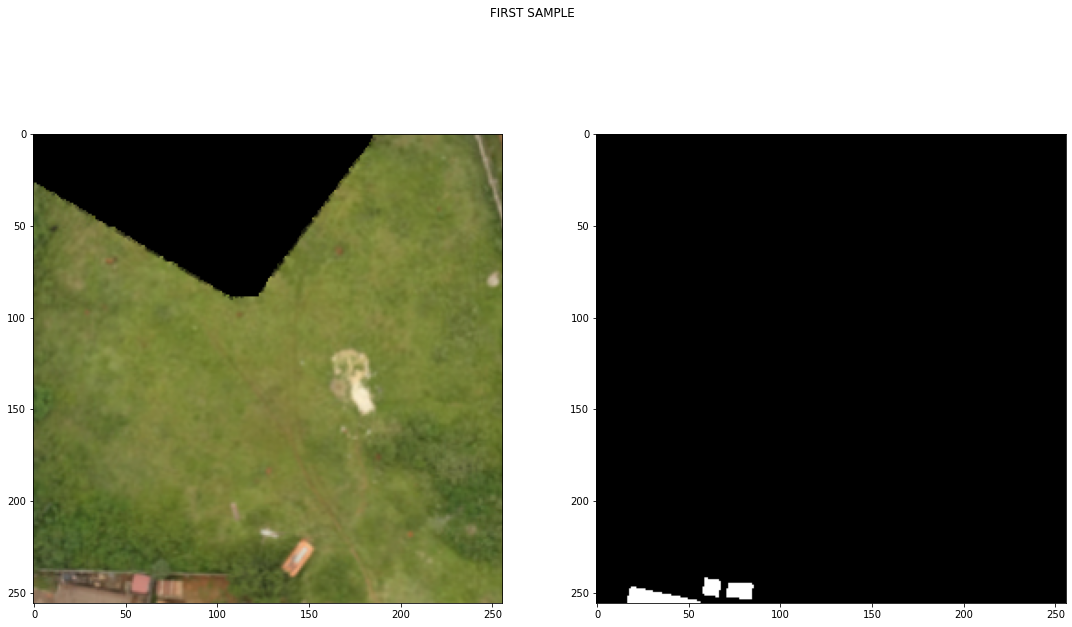

In [ ]:
index = 3
sample_image = sample_train_images[index]
sample_mask = sample_train_masks[index]
plot_images(sample_image, sample_mask, "FIRST SAMPLE")

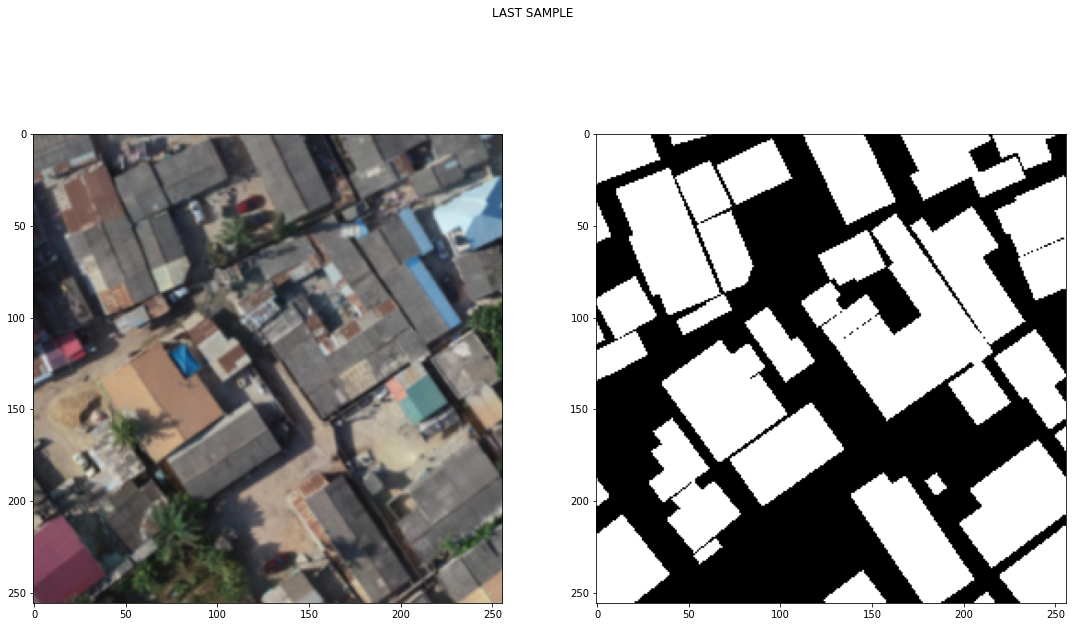

In [ ]:
index = -1 
sample_image = sample_train_images[index]
sample_mask = sample_train_masks[index]
plot_images(sample_image, sample_mask, "LAST SAMPLE")

## Load Samples From the Validation Data

In [ ]:
sample_val_images = open_images(val_images[:10])
sample_val_masks = open_images(val_masks[:10], True)

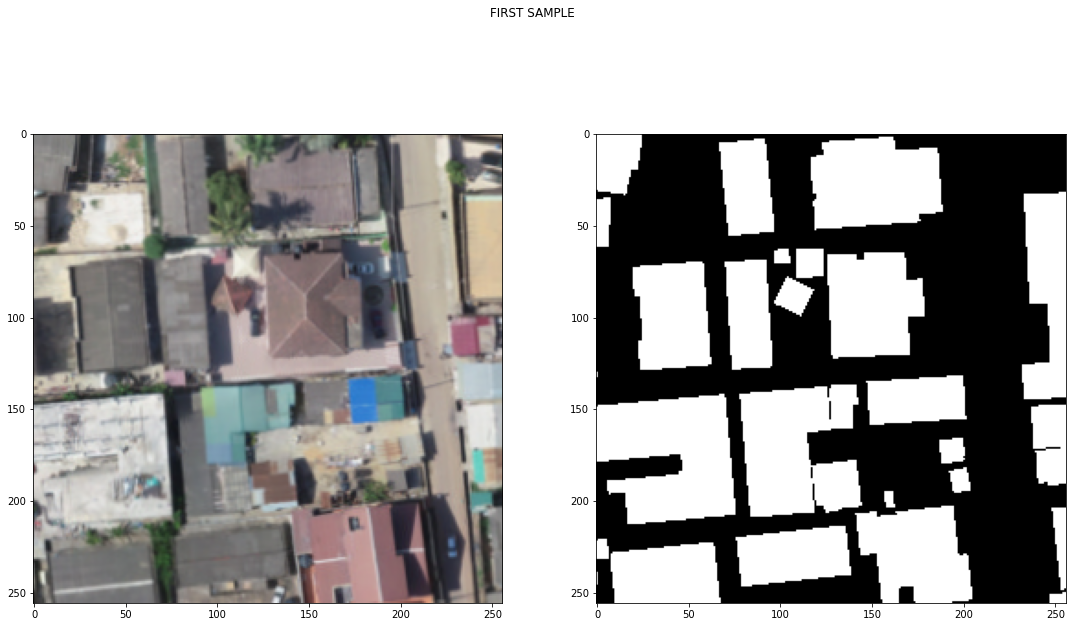

In [ ]:
index = 0 
sample_image = sample_val_images[index]
sample_mask = sample_val_masks[index]
plot_images(sample_image, sample_mask, "FIRST SAMPLE")

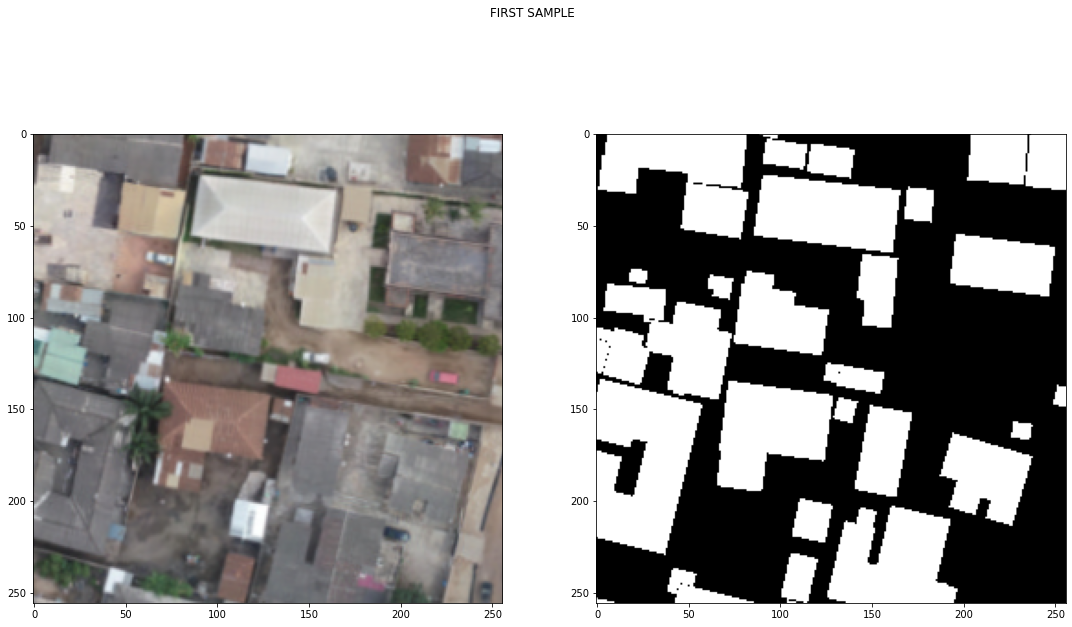

In [ ]:
index = -1
sample_image = sample_val_images[index]
sample_mask = sample_val_masks[index]
plot_images(sample_image, sample_mask, "FIRST SAMPLE")

# UNET

## Helper Functions

## Define model

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
model = sm.Unet('resnet34', classes = 1, activation='sigmoid', encoder_weights='imagenet')

85521592/85521592 [==============================] - 10s 0us/step


In [ ]:
model.compile('Adam',
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

## Define data generator to be used in training

In [ ]:
train_images_path = "/content/data/training/images/"
train_masks_path = '/content/data/training/masks/'

val_images_path = '/content/data/validation/images/'
val_masks_path =  '/content/data/validation/masks/'

In [ ]:
seed = 909 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
image_datagen = ImageDataGenerator(rescale=1/255.) 
mask_datagen = ImageDataGenerator(rescale=1/255.) 


#preprocessing_function = preprocess_input
train_image_generator =image_datagen.flow_from_directory(train_images_path, class_mode=None, seed=seed)
train_mask_generator = mask_datagen.flow_from_directory(train_masks_path, class_mode=None, seed=seed)

val_image_generator = image_datagen.flow_from_directory(val_images_path, class_mode=None, seed=seed)
val_mask_generator = mask_datagen.flow_from_directory(val_masks_path, class_mode=None, seed=seed)


train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 2300 images belonging to 1 classes.
Found 2300 images belonging to 1 classes.
Found 986 images belonging to 1 classes.
Found 986 images belonging to 1 classes.


In [ ]:
batch_size = 20 
steps_per_epoch = 2300// batch_size 
validation_steps = 986 // batch_size 
epochs = 20

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch = steps_per_epoch, validation_data=val_generator,  epochs=epochs, validation_steps = validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
115/115 [==============================] - 84s 728ms/step - loss: 0.2977 - iou_score: 0.5487 - val_loss: 0.9421 - val_iou_score: 0.0298
Epoch 2/20
115/115 [==============================] - 77s 670ms/step - loss: 0.1772 - iou_score: 0.6999 - val_loss: 0.9887 - val_iou_score: 0.0057
Epoch 3/20
115/115 [==============================] - 67s 581ms/step - loss: 0.1470 - iou_score: 0.7442 - val_loss: 0.9955 - val_iou_score: 0.0023
Epoch 4/20
115/115 [==============================] - 66s 578ms/step - loss: 0.1414 - iou_score: 0.7528 - val_loss: 0.9975 - val_iou_score: 0.0013
Epoch 5/20
115/115 [==============================] - 67s 587ms/step - loss: 0.1320 - iou_score: 0.7671 - val_loss: 0.9982 - val_iou_score: 8.8349e-04
Epoch 6/20
115/115 [==============================] - 77s 668ms/step - loss: 0.1356 - iou_score: 0.7619 - val_loss: 0.9717 - val_iou_score: 0.0144
Epoch 7/20
115/115 [==============================] - 67s 581ms/step - loss: 0.1264 - iou_score: 0.7759 - val_loss

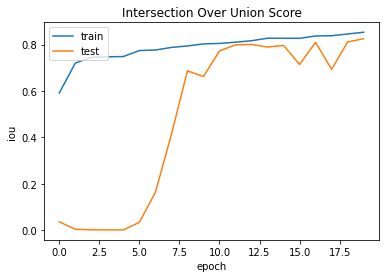

In [ ]:
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Intersection Over Union Score')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save Model For Later Use

In [ ]:
path_to_save_json = '/content/gdrive/MyDrive/Omdena/OpenCities/unet_baseline/model_unet.json'
path_to_save_model = '/content/gdrive/MyDrive/Omdena/OpenCities/unet_baseline/model_unet.h5'
model_json = model.to_json()
with open(path_to_save_json, 'w') as json_file: 
  json_file.write(model_json)

model.save_weights(path_to_save_model)

# Load Model and perform predictions

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, model_from_json
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [ ]:
path_to_load_json = '/content/gdrive/MyDrive/Omdena/OpenCities/unet_baseline/model_unet.json'
path_to_load_model = '/content/gdrive/MyDrive/Omdena/OpenCities/unet_baseline/model_unet.h5'

In [ ]:
# load json and create model
json_file = open(path_to_load_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(path_to_load_model)
print("Loaded model from disk")

Loaded model from disk


In [ ]:
IMAGE_SIZE = 256

def open_images(paths, is_mask=False):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        if is_mask:
          image = np.mean(image, axis=-1)/255.0
        else:
          image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

In [ ]:
def get_image_paths(path, images = True) -> list: 
  """ Returns a list of image or masks paths from a folder""" 
  paths = [path + fname for fname in os.listdir(path)]
  to_return = []
  if images: 
    png_images = []
    for image in paths: 
      if (image.endswith('.tif')): 
        png_images.append(image)
    to_return = png_images
  else: 
    to_return = paths 
  return sorted(to_return) 

In [ ]:
images_1 = "/content/gdrive/MyDrive/Omdena/data/images_v2/2/"
all_image_paths = get_image_paths(images_1) 

In [ ]:
masks_1 = "/content/gdrive/MyDrive/Omdena/data/masks_v2/2/"
all_masks_paths = get_image_paths(masks_1, images=False) 

In [ ]:
all_image_paths=sorted(all_image_paths)
all_masks_paths=sorted(all_masks_paths)

In [ ]:
all_images=open_images(all_image_paths[:30])
all_masks=open_images(all_masks_paths[:30], True)

In [ ]:
def test_prediction(image, true_mask):
  HOT_test_img = preprocess_input(np.array([image]))
  pred_mask = model.predict(HOT_test_img)

  fig = plt.figure(figsize=(10, 5))
  fig.add_subplot(1,3,1)
  plt.title('image')
  plt.imshow(image)
  fig.add_subplot(1,3,2)
  plt.title('true mask')
  plt.imshow(true_mask.reshape((256,256)), cmap='gray')
  fig.add_subplot(1,3,3)
  plt.title('pred mask')
  plt.imshow(pred_mask[0].reshape((256,256)), cmap='gray')

  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 20ms/step


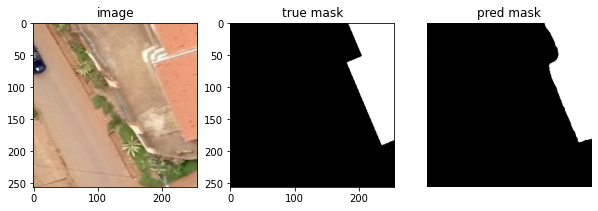

In [ ]:
test_prediction(all_images[-3], all_masks[-3])